# Fine-mapping workflow using summary statistics

Here I implement a workflow that does summary statistics fine-mapping using SuSiE and DAP-G.

SuSiE is implemented in [`susieR`](https://github.com/stephenslab/susieR) (please use version 0.6.1+).

Since we need to analyze the data with both SuSiE and DAP-G we make input format compatible with DAP-G (SuSiE, implemented in R, is more flexible in input format).

update SoS and sos-notebook
```
cd ~/GIT/software/SoS
git pull
pip install ./
```

```
cd ~/GIT/
git clone https://github.com/stephenslab/susieR.git
cd susieR/
R
devtools::install_github("stephenslab/susieR")
# devtools::install_github("stephenslab/dsc", subdir = "dscrutils", force = TRUE)
```

```
sudo apt-get install libgsl-dev
```

```
cd ~/GIT/exec/
mv ../atac-gwas/dap-g ./
source .bashrc
```

In [1]:
%cd /home/min/GIT/atac-gwas/

/home/min/GIT/atac-gwas

## The workflow

In [2]:
!sos run analysis/20181028_SuSiE_Sumstats_Workflow.ipynb -h

usage: sos run analysis/20181028_SuSiE_Sumstats_Workflow.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  susie_bhat
  susie_z
  dap

Global Workflow Options:
  --SNP-block 'chr6_1'
                        Input data, etc
  --rank  SNP_block.split("_")[-1]

  --anno general
  --data-file  path(f'/data/{SNP_block}/Summary_statistics/chunk_{rank}.dat')

  --ld-file  path(f'/data/{SNP_block}/Summary_statistics/chunk_{rank}.LD.txt')

  --prior-file  path(f'/data/{SNP_block}/Summary_statistics/chunk_{rank}.Annotation_{anno}.txt')

  --n 79845 (as int)
  --var-y 1 (as int)
  --out-prefix  path(f'{data_file:an}')

  --[no-]use-annotation (default to True)

Sections
  susi

In [1]:
[global]
# Input data, etc
parameter: SNP_block = "chr1_48"
parameter: rank = SNP_block.split("_")[-1]
parameter: anno = "uniform"
parameter: data_file = path(f'/data/fine_mapping/{SNP_block}/Summary_statistics/chunk_{rank}.dat')
parameter: ld_file = path(f'/data/fine_mapping/{SNP_block}/Summary_statistics/chunk_{rank}.LD.txt')
parameter: prior_file = path(f'/data/fine_mapping/{SNP_block}/Summary_statistics/chunk_{rank}.Annotation_{anno}.txt')
parameter: n = 79845 # sample size in GWAS data
parameter: var_y = 1
parameter: out_prefix = path(f'{data_file:dd}')
def fmtP(x):
    return str(x).replace(".", "p").replace(' ', '_')
if not prior_file.exists():
    anno = "uniform"

### SuSiE $\hat{b}$ version

In [2]:
# Run SuSiE bhat version
[susie_bhat_1]
# when it is length 3 it means column index for variable name, betahat and s;
# when it is length 2 it means column index for variable name and z score
parameter: cols = [1,2,3]
# Set prior effect to 0.0 to estimate from data
parameter: susie_prior_effect = 0.1
# Whether or not to estimate residual variance
parameter: susie_est_residual = True
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
#
prefix = f'{out_prefix}/results/SuSiE_B.L_{L}.prior_{fmtP(susie_prior_effect)}.res_var_{susie_est_residual}'
prior_str = f'read.table({prior_file:r})[,2]' if prior_file.exists() else 'NULL'
#
input: data_file, ld_file
output: f'{prefix}.{anno}.rds'
R: expand = '${ }', stderr = f'{_output:n}.stderr'
    data = read.table(${data_file:ar}, head = F)
    prior = ${prior_str}
    r = as.matrix(read.table(${ld_file:ar}))
    var_names = data[,${cols[0]}]
    bhat = data[,${cols[1]}]
    shat = ${1 if len(cols) == 2 else "data[," + str(cols[2]) + "]"}
    library(susieR)
    s = susie_bhat(bhat, shat, r, ${n}, var_y = ${var_y}, r_tol = 5e-3, L = ${L}, min_abs_corr = 0.1,
                  ${'estimate_prior_variance=TRUE' if susie_prior_effect == 0 else 'scaled_prior_variance=' + str(susie_prior_effect)},
                  ${'estimate_residual_variance=TRUE' if susie_est_residual else 'estimate_residual_variance=FALSE'},
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = bhat / shat
    s$var_names = var_names
    if (${susie_prior_effect} == 0 && ${int(susie_est_residual)}) print(paste(c("Estimated PVE:", round(s$V/s$sigma2, 4)), collapse = ' '))
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, ${L}, '${prefix}')
    saveRDS(s, ${_output:r})

### SuSiE $z$ version

In [3]:
# Run SuSiE Z score version
[susie_z_1]
# when it is length 3 it means column index for variable name, betahat and s;
# when it is length 2 it means column index for variable name and z score
parameter: cols = [1,2,3]
# Set maximum number of effect variables
parameter: L = 5
# Whether or not to keep fit from each iteration,
# for debug purpose.
parameter: track_fit = False
#
prefix = f'{out_prefix}.SuSiE_Z.L_{L}'
prior_str = f'read.table({prior_file:r})[,2]' if prior_file.exists() else 'NULL'
#
input: data_file, ld_file
output: f'{prefix}.{anno}.rds'
R: expand = '${ }', stderr = f'{_output:n}.stderr'
    data = read.table(${data_file:ar}, head = F)
    prior = ${prior_str}
    r = as.matrix(read.table(${ld_file:ar}))
    var_names = data[,${cols[0]}]
    if (${len(cols)} == 3) {
      bhat = data[,${cols[1]}]
      shat = data[,${cols[2]}]
      p_values = 2 * pt(-abs(bhat / shat), df = ${n} - 2)
      z_scores = abs(qnorm(p_values/2)) * sign(bhat)
    } else {
      z_scores = data[,${cols[1]}]
    }
        
    library(susieR)
    s = susie_z(z_scores, r, r_tol = 5e-3, L = ${L}, min_abs_corr = 0.1,
                  prior_weights=prior, track_fit=${"T" if track_fit else "F"})
    s$prior = prior
    s$z = z_scores
    s$var_names = var_names
    if (${"T" if track_fit else "F"}) susie_plot_iteration(s, ${L}, '${prefix}')
    saveRDS(s, ${_output:r})

In [4]:
# Run DAP-G
[dap_1]
# Extra arguments to pass to DAP
parameter: args = ''
prefix = f'{out_prefix}.DAP{"."+fmtp(args) if len(args) else ""}'
input: data_file, ld_file
output: f'{prefix}.{anno}.pkl'
python: expand = '${ }', stderr = f'{_output:n}.stderr'
    import sys
    import pandas as pd
    import numpy as np
    import os
    import pickle

    def run_dap_ss(prefix, data_file, ld_file, n, varY, prior_file = None, args = ''):
        cmd = ['dap-g', '-d_est', data_file, '-d_ld', ld_file, '-d_n', n, '-d_syy', varY, '-o', f'{prefix}.result', '-l', f'{prefix}.stderr', '--all', args]
        if prior_file is not None and os.path.isfile(prior_file):
            cmd.extend(['-p', prior_file])
        cmd = ' '.join(map(str,cmd))
        sys.stderr.write(cmd + '\n')
        os.system(cmd)

    def extract_dap_output(prefix):
        out = [x.strip().split() for x in open(f'{prefix}.result').readlines()]
        pips = []
        clusters = []
        still_pip = True
        for line in out:
            if len(line) == 0:
                continue
            if len(line) > 2 and line[2] == 'cluster_pip':
                still_pip = False
                continue
            if still_pip and (not line[0].startswith('((')):
                continue
            if still_pip:
                pips.append([line[1], float(line[2]), float(line[3]), int(line[4])])
            else:
                clusters.append([len(clusters) + 1, float(line[2]), float(line[3])])
        pips = pd.DataFrame(pips, columns = ['snp', 'snp_prob', 'snp_log10bf', 'cluster'])
        clusters = pd.DataFrame(clusters, columns = ['cluster', 'cluster_prob', 'cluster_avg_r2'])
        clusters = pd.merge(clusters, pips.groupby(['cluster'])['snp'].apply(','.join).reset_index(), on = 'cluster')
        return {'snp': pips, 'set': clusters}

    run_dap_ss(${_output:anr}, ${data_file:ar}, ${ld_file:ar}, ${n}, ${var_y}, ${prior_file:ar}, ${args})
    res = extract_dap_output(${_output:anr})
    res['var_names'] = np.loadtxt(${data_file:ar}, dtype = str, usecols=0)
    ss = np.loadtxt(${data_file:ar}, dtype = float, usecols=(1,2))
    res['z'] = ss[:,0]/ss[:,1]
    res['prior'] = np.loadtxt(${prior_file:ar}, dtype = float, usecols=1)
    pickle.dump(res, open(${_output:ar}, 'wb'))

### DAP $\hat{b}$ version

In [5]:
# Summarize SuSiE & DAP
[susie_bhat_2, susie_z_2, dap_2]
depends: R_library('dscrutils') # can be installed via `devtools::install_github("stephenslab/dsc",subdir = "dscrutils", force = TRUE)`
output: f'{_input:n}.pdf'
R: expand = '${ }', stderr = f'{_output:n}.log'
    s = dscrutils::read_dsc(${_input:r})
    # print something to log
    write(format(Sys.time(), "%a %b %d %X %Y"), stderr())
    library(susieR)
    is_susie = !is.null(s$elbo)
    if (is_susie) {
        write(paste('SuSiE objective:', susie_get_objective(s), "at L =", nrow(s$alpha)), stderr())
    } else {
        snp = s$snp
        snp = snp[match(s$var_names, snp$snp),]
        s$pip = snp$snp_prob
        class(s) = 'susie'
    }
    # make some plots
    pdf(${_output:r}, 8,9,pointsize=16)
    par(mar=c(2,4,0,0), omi=c(0,0,0,0), oma=c(0,0,0,0),mfrow=c(2,1))
    susie_plot(s,y='PIP')
    susie_plot(s,y='z')
    dev.off()
    ordering = order(s$pip, decreasing=T)
    if (is.null(s$prior)) s$prior = rep(1/length(ordering),length(ordering))
    for (i in 1:5) {
        write(paste0("#", i, " pip-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }
    ordering = order(abs(s$z), decreasing=T)
    for (i in 1:5) {
        write(paste0("#", i, " z-ranked SNP ", s$var_names[ordering[i]], " has z-score ", 
              round(s$z[ordering[i]],2), " pip ", round(s$pip[ordering[i]],4), " and prior ", round(s$prior[ordering[i]],4)), stderr())
    }

## Results overview

See an example m6A QTL analysis results below. The $z$ scores suggest this might be a borderline case if any signals exist (need to work out some LD adjusted Bonferroni thresholds to make a formal assessment?). Main observations:

1. SuSiE does not claim any discoveries by default; but DAP-G does, and one of PIP = 1 result from DAP-G is in fact the top z-scored SNP.
2. SuSiE $L=10$ result has worse ELBO than $L=1$, but it resembles z-score plot more.

## DAP-G

In [138]:
!sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb dap -v 2 -s force --anno atac-seq_asca --SNP_block chr5_8

INFO: Running dap_1: Run DAP-G
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.DAP.pkl
INFO: Running dap_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.DAP.pdf
INFO: Workflow dap (ID=8d3a8dc83f815a77) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.DAP.pdf

> /data/chr5_8/Summary_statistics/chunk_8.DAP.pdf (13.9 KiB):

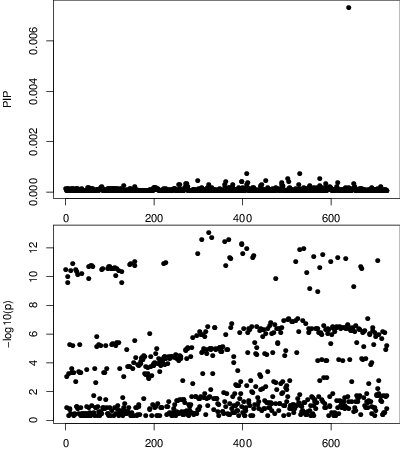

In [139]:
%preview /data/chr5_8/Summary_statistics/chunk_8.DAP.pdf -s png --dpi 50

## SuSiE with z-score

In [171]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_z \
    --SNP_block chr5_8 --L 2 -v 2 -s force

INFO: Running susie_z_1: Run SuSiE Z score version
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_2.uniform.rds
INFO: Running susie_z_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_2.uniform.pdf
INFO: Workflow susie_z (ID=5a153716f2b7ffb7) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.uniform.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.uniform.pdf (13.4 KiB):

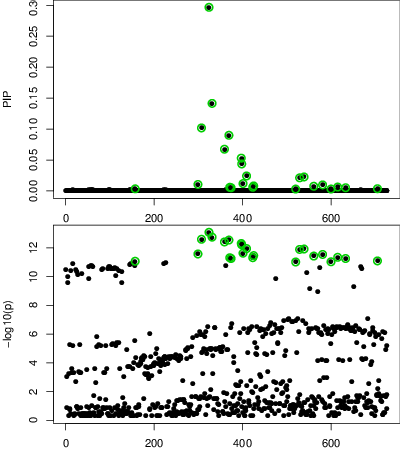

In [185]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.uniform.pdf -s png --dpi 50

In [150]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_z \
    --anno general --SNP_block chr12_9 --L 1 -v 2 -s force

INFO: Running susie_z_1: Run SuSiE Z score version
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_1.general.rds
INFO: Running susie_z_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_1.general.pdf
INFO: Workflow susie_z (ID=acf750ae46830df8) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.general.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.general.pdf (13.3 KiB):

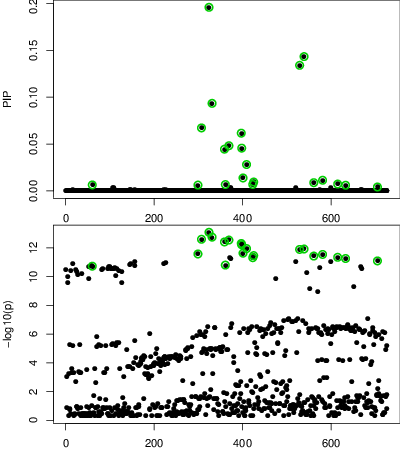

In [187]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_1.general.pdf -s png --dpi 50

In [155]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_z \
    --anno atac-seq --SNP_block chr12_9 --L 1 -v 2 -s force

INFO: Running susie_z_1: Run SuSiE Z score version
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_1.atac-seq.rds
INFO: Running susie_z_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_1.atac-seq.pdf
INFO: Workflow susie_z (ID=10dfcb29d75ddd6d) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_2.atac-seq.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_2.atac-seq.pdf (12.7 KiB):

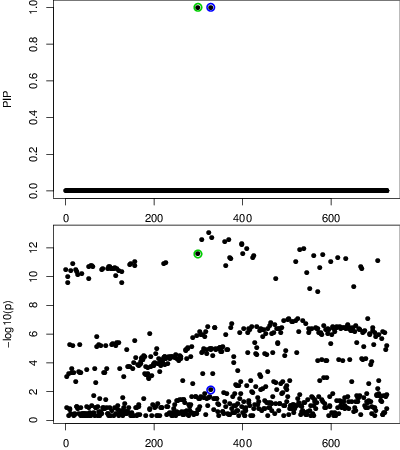

In [191]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_2.atac-seq.pdf -s png --dpi 50

In [161]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_z \
    --anno atac-seq_asca --SNP_block chr12_9 --L 2 -v 2 -s force

INFO: Running susie_z_1: Run SuSiE Z score version
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_2.atac-seq_asca.rds
INFO: Running susie_z_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr12_9/Summary_statistics/chunk_9.SuSiE_Z.L_2.atac-seq_asca.pdf
INFO: Workflow susie_z (ID=e458fa229c695fe7) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_5.atac-seq_asca.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_5.atac-seq_asca.pdf (12.8 KiB):

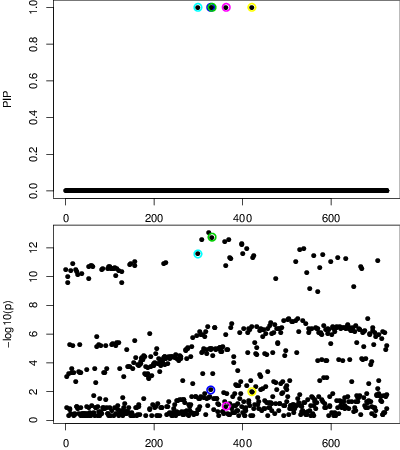

In [195]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_Z.L_5.atac-seq_asca.pdf -s png --dpi 50

## SuSiE with beta and se

In [198]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_bhat \
    --susie-prior-effect 0 --anno atac-seq --SNP_block chr5_8 --L 1 -v 2 -s force

INFO: Running susie_bhat_1: Run SuSiE bhat version
[1] "Estimated PVE: 6e-04"
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_1.prior_0p0.res_var_True.atac-seq.rds
INFO: Running susie_bhat_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_1.prior_0p0.res_var_True.atac-seq.pdf
INFO: Workflow susie_bhat (ID=7937f983856fa536) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_1.prior_0p0.res_var_True.atac-seq.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_1.prior_0p0.res_var_True.atac-seq.pdf (13.4 KiB):

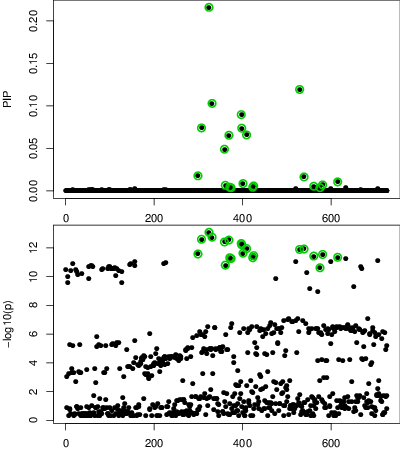

In [199]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_1.prior_0p0.res_var_True.atac-seq.pdf -s png --dpi 50

In [213]:
wf='/home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb'

In [214]:
! sos run {wf}  susie_bhat \
    --no-susie_est_residual --susie-prior-effect 0 --anno atac-seq --SNP_block chr5_8 --L 5 -v 2 -s force

> ! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_bhat --no-susie_est_residual --susie-prior-effect 0 --anno atac-seq --SNP_block chr5_8 --L 5 -v 2 -s force

INFO: Running susie_bhat_1: Run SuSiE bhat version
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.rds
INFO: Running susie_bhat_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf
INFO: Workflow susie_bhat (ID=236ec08048debb72) is executed successfully with 2 completed steps.


%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf (12.8 KiB):

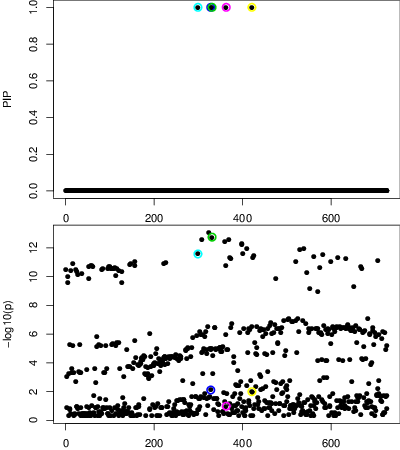

In [204]:
%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf -s png --dpi 50

In [210]:
data='/data/chr5_8/Summary_statistics/chunk_8'

> %preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf -s png --dpi 50

%preview /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf

> /data/chr5_8/Summary_statistics/chunk_8.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf (12.8 KiB):

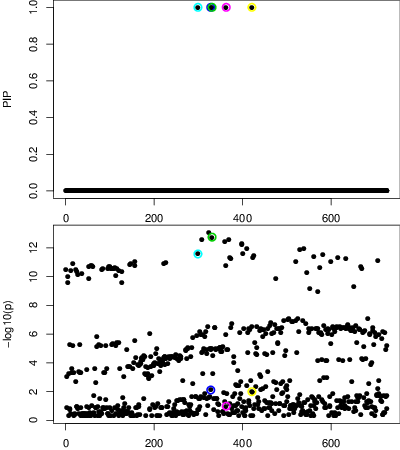

In [212]:
%preview {data}.SuSiE_B.L_5.prior_0p0.res_var_False.atac-seq.pdf -s png --dpi 50

In [41]:
! sos run /home/min/GIT/atac-gwas/analysis/20181028_SuSiE_Sumstats_Workflow.ipynb susie_bhat \
    --susie-prior-effect 0 --anno atac-seq_asca --SNP_block chr14_13 --L 5 -v 2 -s force

INFO: Running susie_bhat_1: Run SuSiE bhat version
INFO: output:   /data/chr14_13/Summary_statistics/chunk_13.SuSiE_B.L_5.prior_0p0.res_var_True.annotation_True.atac-seq_asca.rds
INFO: Running susie_bhat_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /data/chr14_13/Summary_statistics/chunk_13.SuSiE_B.L_5.prior_0p0.res_var_True.annotation_True.atac-seq_asca.pdf
INFO: Workflow susie_bhat (ID=fc89b3ff375b10cc) is executed successfully with 2 completed steps.


%preview /data/chr14_13/Summary_statistics/chunk_13.SuSiE_B.L_5.prior_0p0.res_var_True.annotation_True.atac-seq_asca.pdf

> /data/chr14_13/Summary_statistics/chunk_13.SuSiE_B.L_5.prior_0p0.res_var_True.annotation_True.atac-seq_asca.pdf (10.4 KiB):

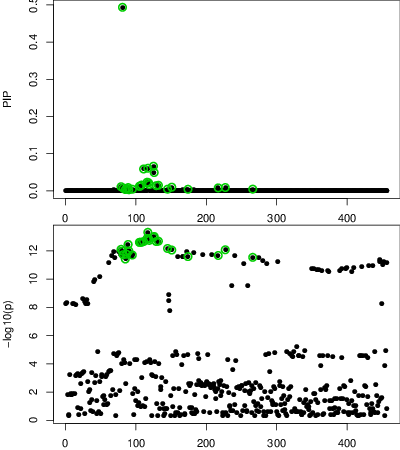

In [42]:
%preview /data/chr14_13/Summary_statistics/chunk_13.SuSiE_B.L_5.prior_0p0.res_var_True.annotation_True.atac-seq_asca.pdf -s png --dpi 50

## SuSiE with a large prior effect

In [27]:
sos run ../20181028_SuSiE_Sumstats_Workflow.ipynb susie --susie-prior-effect 0.5

INFO: Running susie_1: Run SuSiE
INFO: output:   /home/gaow/Documents/GIT/github/random-nbs/random/chr7:44112353-44112749_POLM_-/m6AQTLs.est.SuSiE.L_1t10.prior_0p5.rds
INFO: Running susie_2: Summarize SuSiE & DAP
null device 
          1 
INFO: output:   /home/gaow/Documents/GIT/github/random-nbs/random/chr7:44112353-44112749_POLM_-/m6AQTLs.est.SuSiE.L_1t10.prior_0p5.pdf
INFO: Workflow susie (ID=f77fbc1237a50414) is executed successfully with 2 completed steps.


%preview m6AQTLs.est.SuSiE.L_1t10.prior_0p5.pdf

> m6AQTLs.est.SuSiE.L_1t10.prior_0p5.pdf (10.9 KiB):

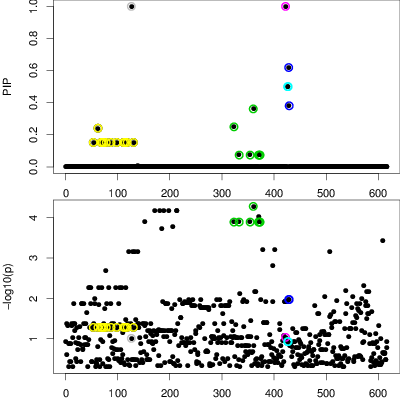

In [28]:
%preview m6AQTLs.est.SuSiE.L_1t10.prior_0p5.pdf -s png --dpi 50